# Differential Equation Model

In [1]:
library(rstudioapi)
library(psych)
library(deSolve)  #for the differential equation solvers
library(ggplot2)   #for plotting
library(nlme)     #for fitting mixed effets models
library(lme4)     # for fitting mixed effects models 
library(zoo)       #for making time-series embedded data
library(reshape2)  #for reshaping data
library(plyr)     # for person-mean centering

Warning message:
"程辑包'rstudioapi'是用R版本4.2.2 来建造的"
Warning message:
"程辑包'psych'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'deSolve'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'ggplot2'是用R版本4.2.3 来建造的"

载入程辑包：'ggplot2'


The following objects are masked from 'package:psych':

    %+%, alpha


Warning message:
"程辑包'lme4'是用R版本4.2.3 来建造的"
载入需要的程辑包：Matrix

Warning message:
"程辑包'Matrix'是用R版本4.2.3 来建造的"

载入程辑包：'lme4'


The following object is masked from 'package:nlme':

    lmList


Warning message:
"程辑包'zoo'是用R版本4.2.3 来建造的"

载入程辑包：'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"程辑包'plyr'是用R版本4.2.3 来建造的"


#### 载入数据

In [2]:
#set filepath for data file
filepath <- "https://quantdev.ssri.psu.edu/sites/qdev/files/AMIBshare_phase2_daily_2019_0501.csv"
#read in the .csv file using the url() function
AMIB_daily <- read.csv(file=url(filepath),header=TRUE)

In [3]:
# recode day
AMIB_daily$daynew <- ifelse(AMIB_daily$id >=300 & AMIB_daily$id < 400, AMIB_daily$day-3, AMIB_daily$day)

#check new data
head(AMIB_daily[which(AMIB_daily$id == 203),c("id","day","daynew")])

,id,day,daynew
,<int>,<int>,<dbl>
1,203,0,0
2,203,1,1
3,203,2,2
4,203,3,3
5,203,4,4
6,203,5,5


In [4]:
head(AMIB_daily[which(AMIB_daily$id == 301),c("id","day","daynew")])

,id,day,daynew
,<int>,<int>,<dbl>
228,301,0,-3
229,301,1,-2
230,301,2,-1
231,301,3,0
232,301,4,1
233,301,5,2


In [5]:
AMIB_daily <- AMIB_daily[,c("id","daynew","affbalance")]

In [6]:
#calculate intraindividual means
AMIB_imeans <- ddply(AMIB_daily, "id", summarize,
                       affbalance_trait = mean(affbalance, na.rm=TRUE))

#merging person-level data into daily data
AMIB_daily <- merge(AMIB_daily,AMIB_imeans,by="id")

#calculating state variables
AMIB_daily$affbalance_state <- AMIB_daily$affbalance - AMIB_daily$affbalance_trait

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


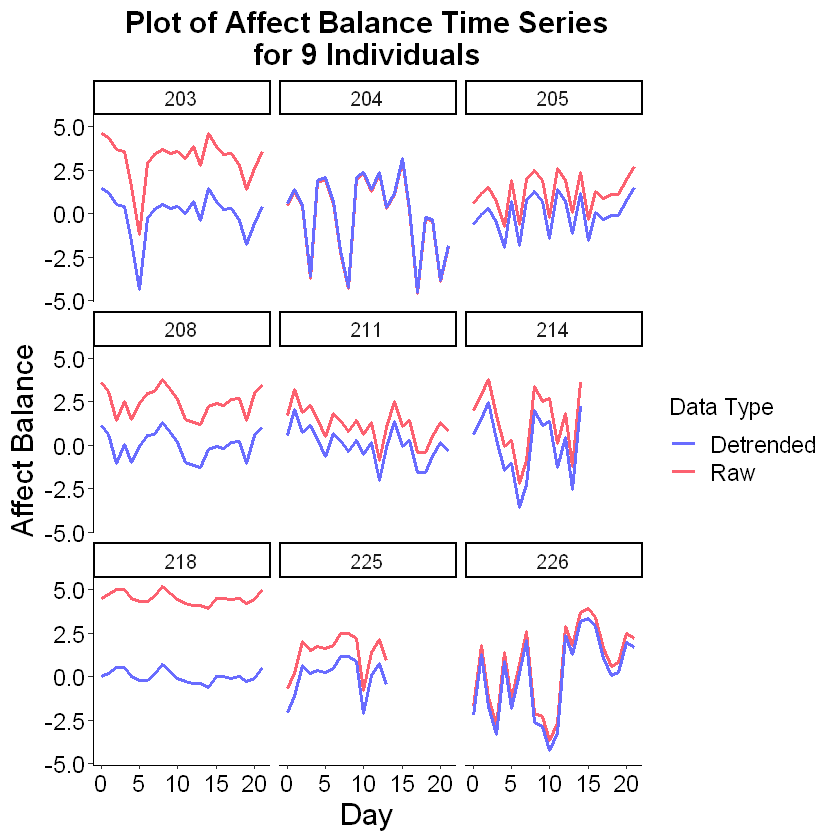

In [7]:
cols <- c("Raw"="#FC6170","Detrended"="#696CFF")

#pdf("Raw&DetrendedAffBalanceDataViz.pdf",width=9,height=5.75)
ggplot(data = AMIB_daily[which(AMIB_daily$id <= 226),], aes(x = daynew)) +
  geom_line(aes(y=affbalance, colour="Raw"), size=1, linetype="solid") +
  geom_line(aes(y=affbalance_state, colour="Detrended"), size=1, linetype="solid") +
  scale_colour_manual(name="Data Type",
                      values=cols, 
                      guide = guide_legend(override.aes = list(
                      linetype = c("solid","solid"),
                      size=1))) +
  xlab("Day") + 
  ylab("Affect Balance") +
  facet_wrap(~id) +
  theme_classic() +
  theme(axis.title=element_text(size=18),
        axis.text=element_text(size=14, colour="black"),
        plot.title=element_text(size=18, hjust=.5,face="bold"),
        strip.text=element_text(size=12),
        legend.text=element_text(size=14),
        legend.title=element_text(size=14)) +
  ggtitle("Plot of Affect Balance Time Series\nfor 9 Individuals")

# Differentiate the Data

### GLLA模型

In [8]:
GLLA <- function(x, embed, tau, deltaT, order=2) {
        L <- rep(1,embed)
        for(i in 1:order) {
            L <- cbind(L,(((c(1:embed)-mean(1:embed))*tau*deltaT)^i)/factorial(i))
            }
        
        W <- solve(t(L)%*%L)%*%t(L)
        #EMat <- Embed(x,embed,1)
        #replacement for Embed for embed = 5
          xzoo <- zoo(x)
      xzooembed <- cbind(lag(xzoo,k=-2), lag(xzoo,k=-1), xzoo, lag(xzoo,k=1), lag(xzoo,k=2))
      EMat <- as.matrix(xzooembed)
    #Continuation
        Estimates <- EMat%*%t(W)

        return(Estimates)
        }

In [9]:
# This is the for-loop that will go through the data and calculate derivatives.
# it goes through all of the elements of 'curr_data', and uses GLLA
idlist <- unique(AMIB_daily$id)
#create open object
derivdf <- data.frame()
    for(i in 1:length(idlist)){
      #i <- 1 #for testing
        curr_data = AMIB_daily[which(AMIB_daily$id == idlist[i]),]
        derivs_x = GLLA(x = curr_data[,'affbalance_state'], embed = 5, tau = 1, deltaT = 1, order = 2)
        colnames(derivs_x) = c('x_est', 'dx_est', 'd2x_est')
        derivs_plus = cbind(curr_data, derivs_x)
    derivdf<- rbind(derivdf,derivs_plus)
    }

In [10]:
round(head(derivdf[,c("id","daynew","affbalance_state","x_est","dx_est","d2x_est")]),2)

,id,daynew,affbalance_state,x_est,dx_est,d2x_est
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,203,0,1.44,NA,NA,NA
2,203,1,1.24,NA,NA,NA
3,203,2,0.54,0.85,-0.68,-0.43
4,203,3,0.44,0.13,-1.33,-0.87
5,203,4,-1.56,-2.12,-0.64,1.09
6,203,5,-4.36,-2.80,0.09,1.70


In [11]:
describe(derivdf[,c("affbalance_state","x_est","dx_est","d2x_est")])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
affbalance_state,1,627,-2.151112e-19,1.4388118,0.15000000,0.06878198,1.293905,-5.680000,4.395238,10.075238,-0.53309756,0.6060793,0.05746061
x_est,2,503,-4.322274e-02,1.1526467,0.05857143,-0.02186499,1.065354,-5.028571,3.487143,8.515714,-0.28977528,0.8514126,0.05139398
dx_est,3,503,2.395626e-03,0.5389493,-0.03000000,-0.01394541,0.489258,-1.660000,1.930000,3.590000,0.27098555,0.5509287,0.02403056
d2x_est,4,503,1.557796e-02,0.7616762,0.04285714,0.01306274,0.656580,-2.600000,2.828571,5.428571,0.07498893,0.8366534,0.03396146


# 微分可视化

Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."


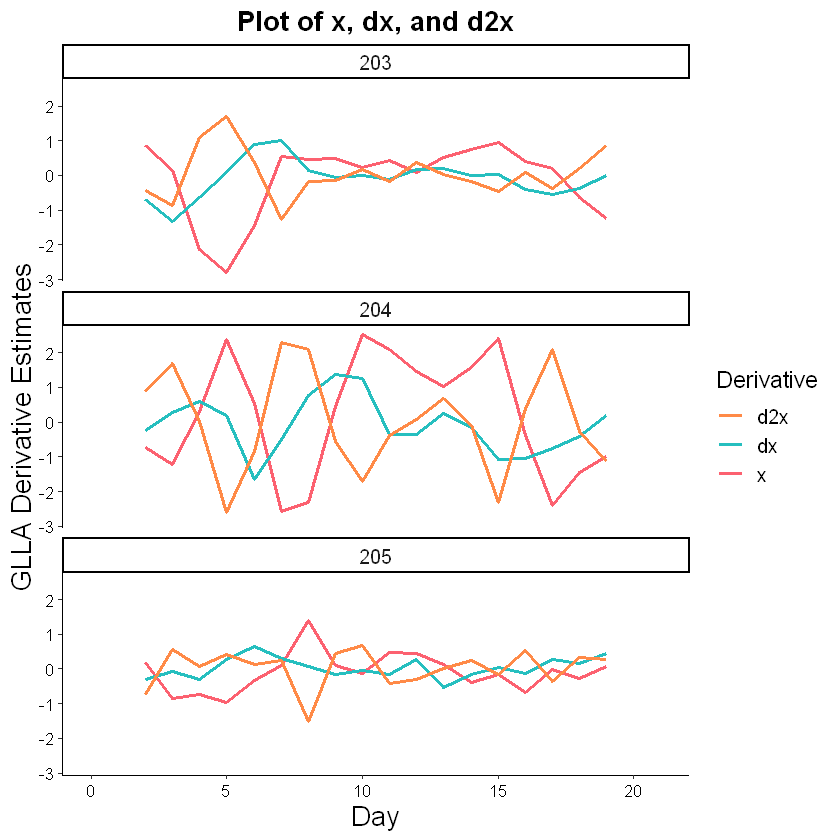

In [12]:
#pdf("DerivEstimatesDataViz.pdf",width=9, height=5.75)
cols <- c("x"="#FC6170", "dx"="#26BFBF", "d2x"="#FF8A47")
ggplot(data = derivdf[which(derivdf$id <= 205),], aes(x = daynew)) +
  geom_line(aes(y=x_est, colour="x"), linetype = "solid", size=1) +
  geom_line(aes(y=dx_est, colour="dx"), linetype = "solid", size=1) +
  geom_line(aes(y=d2x_est, colour="d2x"), linetype = "solid", size=1) +
  scale_colour_manual(name="Derivative",
                      values=cols, 
                      guide = guide_legend(override.aes = list(
                      linetype = c("solid","solid", "solid"),
                      size=1))) +
  xlab("Day") + 
  ylab("GLLA Derivative Estimates") +
  facet_wrap(~id,nrow=5) +
  theme_classic() +
  theme(axis.title=element_text(size=16),
        axis.text=element_text(size=10, colour="black"),
        plot.title=element_text(size=16, hjust=.5,face="bold"),
        legend.title=element_text(size=14),
        legend.text=element_text(size=12),
        strip.text=element_text(size=12)) +
  ggtitle("Plot of x, dx, and d2x")

# Fit Damped Linear Oscillator (DLO)

In [13]:
dlo_modfit <- nlme(d2x_est ~ eta_x*x_est + zeta_x*dx_est,
                        fixed = eta_x + zeta_x ~ 1,
                        random = eta_x ~ 1|id,
                        start = c(eta_x  = -0.80,    # frequency of x
                                  zeta_x  = -0.01),    # damping of x
                        data=derivdf,
                        na.action = na.exclude,
                        verbose=TRUE)


**Iteration 1
LME step: Loglik: -314.5108, nlminb iterations: 1
reStruct  parameters:
      id 
1.130059 
 Beginning PNLS step: ..  completed fit_nlme() step.
PNLS step: RSS =  96.47977 
 fixed effects: -0.5438015  -0.0253445  
 iterations: 3 
Convergence crit. (must all become <= tolerance = 1e-05):
       fixed     reStruct 
6.054371e-01 2.168754e-06 

**Iteration 2
LME step: Loglik: -314.5108, nlminb iterations: 1
reStruct  parameters:
      id 
1.130062 
 Beginning PNLS step: ..  completed fit_nlme() step.
PNLS step: RSS =  96.47977 
 fixed effects: -0.5438015  -0.0253445  
 iterations: 1 
Convergence crit. (must all become <= tolerance = 1e-05):
       fixed     reStruct 
0.000000e+00 1.734997e-13 


In [14]:
summary(dlo_modfit)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: d2x_est ~ eta_x * x_est + zeta_x * dx_est 
  Data: derivdf 
       AIC      BIC    logLik
  637.0216 653.9039 -314.5108

Random effects:
 Formula: eta_x ~ 1 | id
            eta_x  Residual
StdDev: 0.1414668 0.4379597

Fixed effects:  eta_x + zeta_x ~ 1 
            Value  Std.Error  DF    t-value p-value
eta_x  -0.5438015 0.03293993 472 -16.508886   0.000
zeta_x -0.0253445 0.03643417 472  -0.695625   0.487
 Correlation: 
       eta_x
zeta_x 0.004

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-4.033033909 -0.608529547  0.003441901  0.602124636  3.200024742 

Number of Observations: 503
Number of Groups: 30 

In [15]:
intervals(dlo_modfit)

Approximate 95% confidence intervals

 Fixed effects:
             lower       est.       upper
eta_x  -0.60839970 -0.5438015 -0.47920324
zeta_x -0.09679526 -0.0253445  0.04610626

 Random Effects:
  Level: id 
               lower      est.     upper
sd(eta_x) 0.09463504 0.1414668 0.2114742

 Within-group standard error:
    lower      est.     upper 
0.4109590 0.4379597 0.4667344 